In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_excel('hackathon.xlsx', parse_dates=True)

data.head(5)

,TIME_STAMP,SERVER_NAME,DOWNLOAD,UPLOAD
0,2024-03-05 18:25:00,10.0.901.xx Server 1,11927.017,424.700
1,2024-03-05 18:20:00,10.0.901.xx Server 1,19703.467,525.575
2,2024-03-05 18:15:00,10.0.901.xx Server 1,26349.663,631.144
3,2024-03-05 18:10:00,10.0.901.xx Server 1,26068.494,623.673
4,2024-03-05 18:05:00,10.0.901.xx Server 1,25814.357,620.701


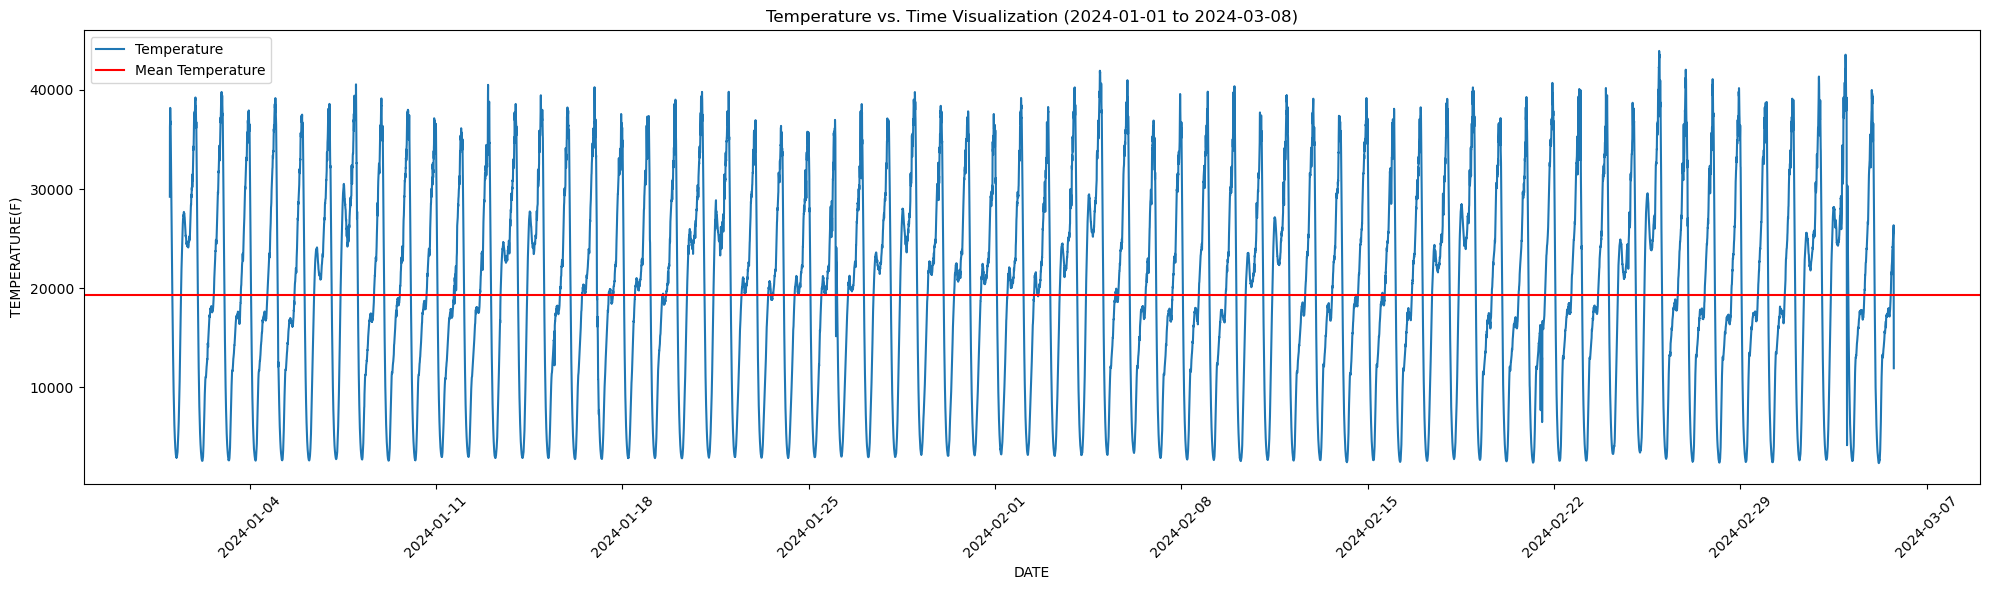

In [3]:
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-03-08')

df_filtered = data[(data['TIME_STAMP'] >= start_date) & (data['TIME_STAMP'] <= end_date)]

plt.figure(figsize=(20, 6))  
plt.plot(df_filtered['TIME_STAMP'], df_filtered['DOWNLOAD'], label='Temperature')
plt.axhline(y=df_filtered['DOWNLOAD'].mean(), color='r', linestyle='-', label='Mean Temperature')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))  # Her 7 günde bir işaret

plt.xlabel('DATE')
plt.ylabel('TEMPERATURE(F)')
plt.legend()
plt.title(f'Temperature vs. Time Visualization ({start_date.date()} to {end_date.date()})')

plt.xticks(rotation=45) 
plt.tight_layout()  


In [4]:
eksik_degerler = data.isna().sum()
print(eksik_degerler)
data.describe()

TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       2
UPLOAD         2
dtype: int64


,TIME_STAMP,DOWNLOAD,UPLOAD
count,35429,35427.000000,35427.000000
mean,2024-01-03 13:59:16.925117696,19052.251090,482.140941
min,2023-11-02 10:10:00,2335.885000,57.749000
25%,2023-12-03 12:05:00,11342.646000,264.406500
50%,2024-01-03 13:55:00,18816.920000,475.543000
75%,2024-02-03 15:45:00,26627.177000,668.998000
max,2024-03-05 18:25:00,43930.614000,1670.995000
std,NaN,10213.032412,267.930799


In [5]:
data['DOWNLOAD'].ffill(inplace=True)
data['UPLOAD'].ffill(inplace=True)

In [6]:
eksik_degerler = data.isna().sum()
print(eksik_degerler)
data.describe()

TIME_STAMP     0
SERVER_NAME    0
DOWNLOAD       0
UPLOAD         0
dtype: int64


,TIME_STAMP,DOWNLOAD,UPLOAD
count,35429,35429.000000,35429.000000
mean,2024-01-03 13:59:16.925117696,19051.934416,482.150228
min,2023-11-02 10:10:00,2335.885000,57.749000
25%,2023-12-03 12:05:00,11340.817000,264.408000
50%,2024-01-03 13:55:00,18816.920000,475.543000
75%,2024-02-03 15:45:00,26627.090000,669.031000
max,2024-03-05 18:25:00,43930.614000,1670.995000
std,NaN,10213.146798,267.931104


In [7]:
data['hour'] = data['TIME_STAMP'].dt.hour
data['minute'] = data['TIME_STAMP'].dt.minute
data['day_of_week'] = data['TIME_STAMP'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [8]:
data['TIME_STAMP'] = pd.to_datetime(data['TIME_STAMP'])
data.set_index('TIME_STAMP', inplace=True)
data.sort_index(inplace=True)

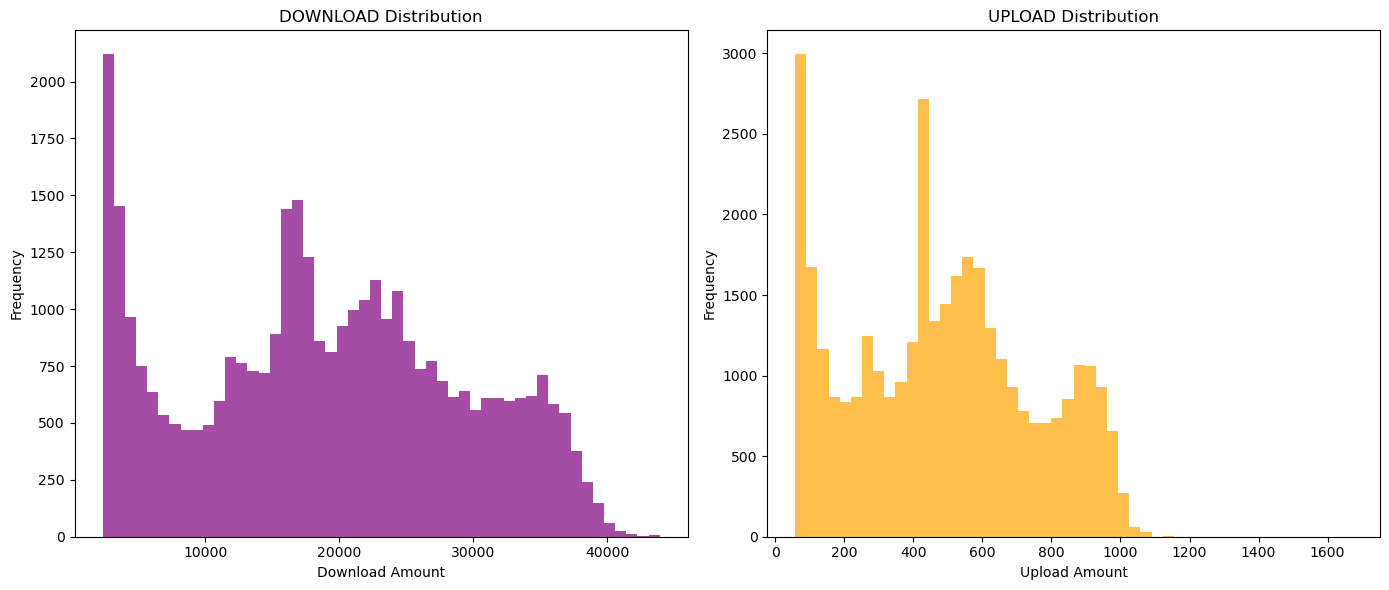

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(data['DOWNLOAD'].dropna(), bins=50, color='purple', alpha=0.7)
ax[0].set_title('DOWNLOAD Distribution')
ax[0].set_xlabel('Download Amount')
ax[0].set_ylabel('Frequency')

ax[1].hist(data['UPLOAD'].dropna(), bins=50, color='orange', alpha=0.7)
ax[1].set_title('UPLOAD Distribution')
ax[1].set_xlabel('Upload Amount')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



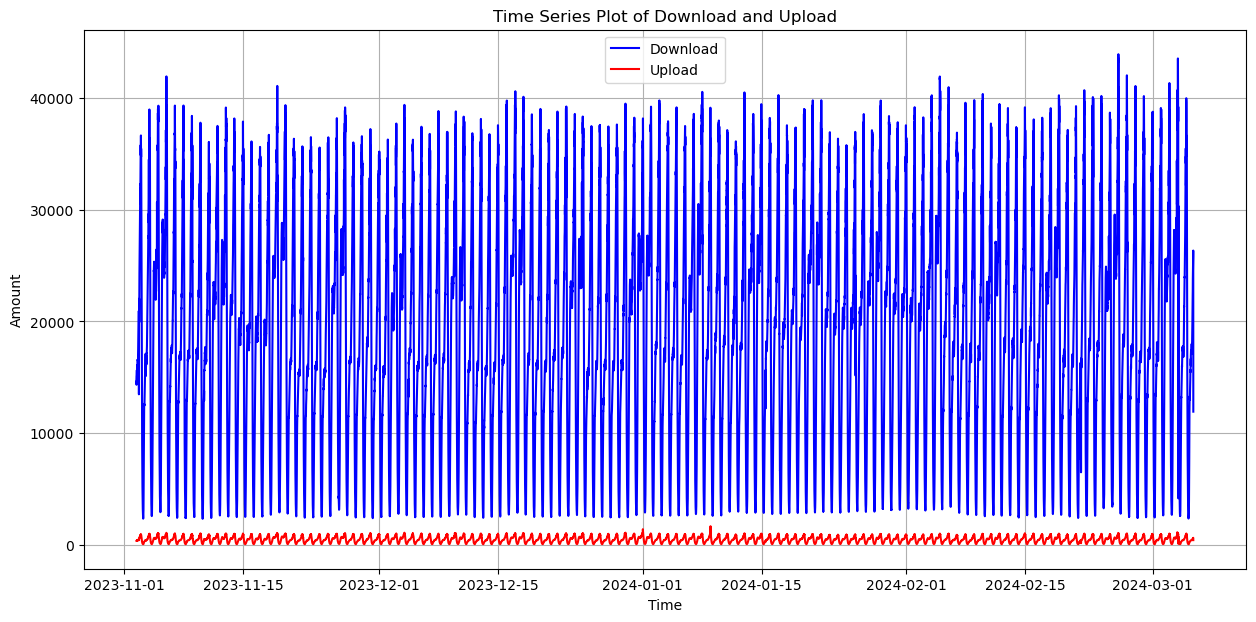

In [10]:
plt.figure(figsize=(15, 7))
plt.plot(data.index, data['DOWNLOAD'], label='Download', color='blue')
plt.plot(data.index, data['UPLOAD'], label='Upload', color='red')
plt.title('Time Series Plot of Download and Upload')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result_download = adfuller(data['DOWNLOAD'])
result_upload = adfuller(data['UPLOAD'])

def check_stationarity(results):
    p_value = results[1]
    return "Stationary" if p_value < 0.05 else "Non-Stationary"

print(f"DOWNLOAD ADF Statistic: {result_download[0]}, p-value: {result_download[1]}")
print(f"UPLOAD ADF Statistic: {result_upload[0]}, p-value: {result_upload[1]}")

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['DOWNLOAD'].dropna(), ax=axes[0])
plot_pacf(data['DOWNLOAD'].dropna(), ax=axes[1])
plt.suptitle('ACF and PACF for DOWNLOAD', fontsize=16)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(data['UPLOAD'].dropna(), ax=axes[0])
plot_pacf(data['UPLOAD'].dropna(), ax=axes[1])
plt.suptitle('ACF and PACF for UPLOAD', fontsize=16)
plt.show()           # güçlü mevsimsellik veya trend olabilir yani Bu durum, verilerin zaman içindeki belirli bir düzende tekrarlandığını gösterebilir.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model_download = ARIMA(data['DOWNLOAD'], order=(1,0,1))  
fit_model_download = model_download.fit()

model_upload = ARIMA(data['UPLOAD'], order=(1,0,1)) 
fit_model_upload = model_upload.fit()

predict_download = fit_model_download.get_prediction(start=data.index[-100], end=data.index[-1])
predict_mean_download = predict_download.predicted_mean
ci_download = predict_download.conf_int() #güven aralığı

predict_upload = fit_model_upload.get_prediction(start=data.index[-100], end=data.index[-1])
predict_mean_upload = predict_upload.predicted_mean
ci_upload = predict_upload.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['DOWNLOAD'][-100:], label='Actual DOWNLOAD', color='blue') #gerçek
plt.plot(data.index[-100:], predict_mean_download, label='Predicted DOWNLOAD', color='red') #download tahmini

plt.title('Download: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Download Amount')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(data.index[-100:], data['UPLOAD'][-100:], label='Actual UPLOAD', color='blue')
plt.plot(data.index[-100:], predict_mean_upload, label='Predicted UPLOAD', color='red')
plt.title('Upload: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Upload Amount')
plt.legend()
plt.grid(True)
plt.show()

print(fit_model_download.summary())
print(fit_model_upload.summary())              #model Arıma(1,0,1)

In [ ]:
br_timestamp = pd.Timestamp('2024-03-05 18:25:00')
br_download = 11927.017
br_upload = 424.7

forecast_download = fit_model_download.get_forecast(steps=1)
forecast_upload = fit_model_upload.get_forecast(steps=1)

predict_mean_download = forecast_download.predicted_mean
predict_ci_download = forecast_download.conf_int()

predict_mean_upload = forecast_upload.predicted_mean
predict_ci_upload = forecast_upload.conf_int()

print(f"Tahmin edilen DOWNLOAD değeri: {predict_mean_download.iloc[0]}")
print(f"DOWNLOAD için güven aralığı: {predict_ci_download.iloc[0, 0]} - {predict_ci_download.iloc[0, 1]}")

print(f"Tahmin edilen UPLOAD değeri: {predict_mean_upload.iloc[0]}")
print(f"UPLOAD için güven aralığı: {predict_ci_upload.iloc[0, 0]} - {predict_ci_upload.iloc[0, 1]}")

is_anomaly_download = not (predict_ci_download.iloc[0, 0] <= br_download <= predict_ci_download.iloc[0, 1])
is_anomaly_upload = not (predict_ci_upload.iloc[0, 0] <= br_upload <= predict_ci_upload.iloc[0, 1])

print(f"Is DOWNLOAD an anomaly? {is_anomaly_download}")
print(f"Is UPLOAD an anomaly? {is_anomaly_upload}")